In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Classification2D/Source'

/content/drive/MyDrive/Classification2D/Source


In [ ]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Classification2D/Source/outputs/csv/data.csv', index_col=0)
data 

,image_ids,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,image_paths,Images
0,50a418190bc3fb1ef1633bf9678929b3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
1,21a10246a5ec7af151081d0cd6d65dc9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
2,9a5094b2563a1ef3ff50dc5c7ff71345,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
3,051132a778e61a86eb147c7c6f564dfe,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
4,063319de25ce7edb9b1c6b8881290140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,7c0ddf911bdb68fca14d7172486827cb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
14996,209e3a5c73c1195d805dd25d086b3c6d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
14997,1bea772246421c37929f8cbc43dba729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...
14998,ae86eabab95525b41b8e79883ff1cef9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Classification2D/vinbig...,/content/drive/MyDrive/Classification2D/Source...


Get val_dl

In [ ]:
from repos.training.data.get_dl import get_dloader

data train: 13500
data val: 1500


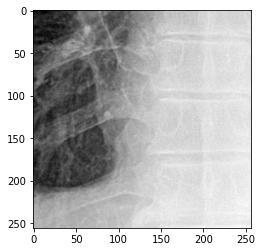

torch.Size([3, 256, 256])
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
train_dl, val_dl = get_dloader(df=data, fold=0)

In [ ]:
img, target = next(iter(val_dl))
print(img.shape)
print(target.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 14])


Models

In [ ]:
from torchvision.models import densenet121
import torchvision.transforms as transforms
from pathlib import Path

class ChexNet(nn.Module):
    def __init__(self, trained=False):    
        super().__init__()

        self.backbone = densenet121(False).features
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                 nn.Flatten(),
                                 nn.Linear(1024, 14))

    def forward(self, x):
        return self.head(self.backbone(x))

chexnet = ChexNet(trained=True)

In [ ]:
from torchvision.models import densenet121
from repos.modules.commons import GlobalAverage
from repos.modules.attentions import SAModule
from repos.training.models.GCN import GCN

def classifier(gcn=True, pretrained_path=None, freeze_feature=False, n_class=14): 
    features = chexnet.backbone
    final_width = chexnet.head[-1].in_features
    print('final_width', final_width)

    if gcn:
      embedding_path = "/content/drive/MyDrive/Classification2D/Source/outputs/embeddings_14.npy"
      correlation_path = "/content/drive/MyDrive/Classification2D/Source/outputs/correlations_14.npy"
      embeddings = np.load(embedding_path)
      corr_matrix = np.load(correlation_path)
      print("embeddings.shape", embeddings.shape)
      print("corr_matrix.shape", corr_matrix.shape)
      classifier = nn.Sequential(*[
                        GlobalAverage(),
                        GCN(300, final_width, embeddings, corr_matrix)
                      ])

    else:
      classifier = nn.Sequential(*[     
          GlobalAverage(keepdims=True),
          nn.Flatten(), 
          nn.Linear(final_width, n_class), 
          nn.Sigmoid()
         ])
    
    model = nn.Sequential()
    model.features = features
    model.attention = SAModule(final_width)
    model.classifier = classifier

    update_model = nn.Sequential()
    update_model.features = model.features
    update_model.dropout  = nn.Dropout(0.5)
    update_model.attention = SAModule(final_width)
    update_model.classifier = classifier
    # update_model.classifier = nn.Sequential(*[     
    #       GlobalAverage(keepdims=True),
    #       nn.Flatten(), 
    #       nn.Linear(final_width, n_class), 
    #       nn.Sigmoid()
    #      ])
    
    if pretrained_path is not None:
      print(pretrained_path)
      cp = torch.load(pretrained_path, map_location="cpu")
      update_model.load_state_dict(cp['model_state_dict'])
      

    if freeze_feature:
      print("Freeze feature")
      for p in update_model.features.parameters():
          p.requires_grad = False

    return update_model

# pretrained_path = '/content/drive/MyDrive/Classification2D/Source/outputs/checkpoints/best_GCN_chext_fold0_20220511.pt'
pretrained_path = '/content/drive/MyDrive/Classification2D/Source/outputs/checkpoints/best_GCN_dropout_fold0_20220510.pt'

model = classifier(gcn = True, pretrained_path = pretrained_path, freeze_feature = False, n_class=14)

x = torch.rand(1,3,256,256)
x = x.cuda()
model = model.cuda()
print(model(x).shape)
print(model(x))


final_width 1024
embeddings.shape (14, 300)
corr_matrix.shape (14, 14)
/content/drive/MyDrive/Classification2D/Source/outputs/checkpoints/best_GCN_dropout_fold0_20220510.pt
torch.Size([1, 14])
tensor([[0.4825, 0.8010, 0.4556, 0.5067, 0.4747, 0.3119, 0.5975, 0.6266, 0.4900,
         0.5249, 0.7311, 0.5164, 0.6502, 0.4959]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Test

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

class AUCScore(nn.Module):

    def __init__(self, binary=True, classes=None):
        super().__init__()

        self.classes = classes
        self.binary  = binary

    def forward(self, preds, trues):
        if self.binary:
            preds = (preds >= 0.5).float()
        else:
            trues = trues[:, 1:, ...]
            preds = preds.argmax(dim=1)
            preds = torch.stack([(preds == i).float() for i in range(1, trues.shape[1])], dim=1)

        auc_score = []
        for i in range (trues.shape[1]):
            pred = preds[:, i]
            true = trues[:, i]

            if len(torch.unique(true)) == 2:
              auc_score.append(roc_auc_score(true, pred))
            elif len(torch.unique(true)) != 2:
              if torch.all(pred == true): auc_score.append(1)
              else:  
                auc_score.append(1)

        if self.classes is not None:
          results = {f"{c}_AUC": auc_score[i] for i, c in enumerate(self.classes)}
        else:
          results = np.mean(auc_score)

        return results     

In [ ]:
from tqdm import tqdm 

classes = np.load('/content/drive/MyDrive/Lung_Xray/classification/outputs/colums_14.npy')

def test(model, dl):
    trues = []
    preds = []

    model.eval()
    with torch.no_grad():
      for img, true in tqdm(dl):
          img = img.to(device)
          true = true.to(device)
              
          pred = model(img)
              
          trues.append(true.detach().cpu()) 
          preds.append(pred.detach().cpu())

    trues = torch.cat(trues)
    preds = torch.cat(preds)

    avg_aucs = AUCScore(binary=True, classes=None)(preds, trues)
    print('\n')
    print(f'The average AUROC is {avg_aucs:.3}')

    class_aucs = AUCScore(binary=True, classes=classes)(preds, trues)
    for key, value in zip(class_aucs.keys(), class_aucs.values()):
            print(key, ':' , f'{value:.3f}', end='\n') 

    return trues, preds

In [ ]:
trues, preds = test(model, val_dl)

100%|██████████| 23/23 [00:07<00:00,  2.88it/s]



The average AUROC is 0.827
Aortic enlargement_AUC : 0.911
Atelectasis_AUC : 0.803
Calcification_AUC : 0.760
Cardiomegaly_AUC : 0.898
Consolidation_AUC : 0.792
ILD_AUC : 0.835
Infiltration_AUC : 0.787
Lung Opacity_AUC : 0.808
Nodule Mass_AUC : 0.787
Other lesion_AUC : 0.833
Pleural effusion_AUC : 0.819
Pleural thickening_AUC : 0.853
Pneumothorax_AUC : 0.869
Pulmonary fibrosis_AUC : 0.817


In [ ]:
from sklearn.metrics import roc_curve, auc

class_rocs = {f"{c}_ROC": roc_curve(trues[:, i], preds[:, i]) for i, c in enumerate(classes)}

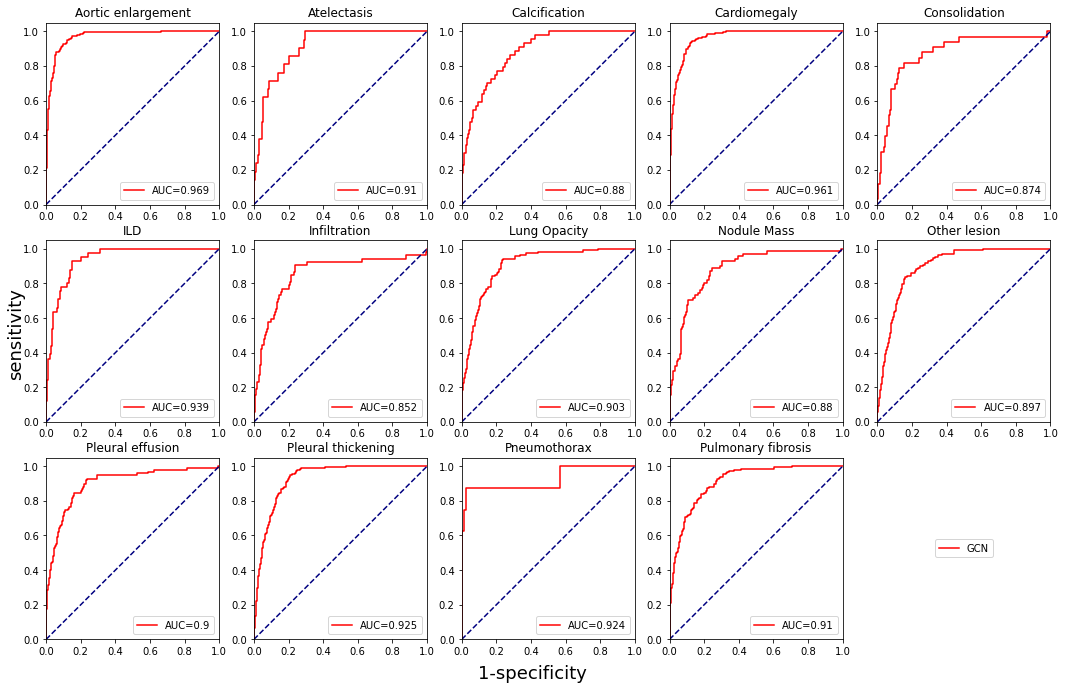

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(18, 12))

for i, ax in enumerate(axes.flat):
    if i == 14:
        ax.plot(0, 0, c='r', label='GCN')
        ax.legend( loc='center')
        ax.set_axis_off()
        break
        
    # densenet
    c = classes[i]
    fpr, tpr, threshold = class_rocs[f"{c}_ROC"]
    classes_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, c='r', label=f'AUC={classes_auc:.3}')
    
    # enhance
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_aspect('equal', 'box')
    ax.set_title(c)
    ax.legend(loc='lower right')

fig.text(0.5, 0.1, '1-specificity', ha='center', fontsize=18)
fig.text(0.095, 0.5, 'sensitivity', va='center', rotation='vertical', fontsize=18)

plt.subplots_adjust(hspace=0.0001)
fig.savefig('dense_roc.png')